**Sources:**

The code is a further development of this preliminary project:

[1] https://github.com/bjorneme/preliminary/tree/main

The state-of-the-art model used as inspiration for multi-label classification on ChestX-ray14 is:

[2] https://github.com/syednabilashraf/SynthEnsemble/tree/main

The code used for develop BYOL architecture is:

[3] https://docs.lightly.ai/self-supervised-learning/examples/byol.html

**Import Libraries**

In [1]:
pip install lightly mambavision transformers mamba_ssm timm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import zipfile

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

# BYOL library
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NegativeCosineSimilarity
from lightly.utils.scheduler import cosine_schedule

# Hugging Face transformers to load the MambaVision model
from transformers import AutoModel

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [3]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Model
MODEL_NAME = "nvidia/MambaVision-T2-1K"

# Disease labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Parameters BYOL pre-training
LEARNING_RATE_BYOL = 0.06
EPOCHS_BYOL = 100
BATCH_SIZE_BYOL = 128

# Parameters training
LEARNING_RATE = 0.001
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 3
EPOCHS_FINE_TUNING = 100
BATCH_SIZE = 32

# Parameters early stopping
EARLY_STOPPING_PATIENCE = 10

# Parameters learning rate scheduler
LEARNING_RATE_SCHEDULER_PATIENCE = 5
LEARNING_RATE_SCHEDULER_MODE = 'min'
LEARNING_RATE_SCHEDULER_FACTOR = 0.1

# Other parameters
SEED = 42
NUM_WORKERS = 64

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [4]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [5]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [6]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [7]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 78614
Validation size: 11212
Test size: 22294


**Define Dataset for Chest X-ray images**

In [8]:
class ChestXrayDataset(Dataset):
    """
    Create dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get image and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation on image
        image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [9]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [10]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: BYOL Pre-training**

**Define the BYOL transformations**

In [12]:
def get_xray_transform():
    return transforms.Compose([
        
        # Convert image to PIL format
        transforms.ToPILImage(),

        # Convert to 3 channels
        transforms.Grayscale(num_output_channels=3),

        # Randomly resize the image
        transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),

        # Apply random horizontal flip
        transforms.RandomHorizontalFlip(),

        # Randomly rotate the image with ±10 degrees
        transforms.RandomRotation(10),

        # Apply random brightness and contrast
        transforms.ColorJitter(
            brightness=(0.8, 1.2),
            contrast=(0.8, 1.2)
        ),

        # Convert the image to a PyTorch tensor
        transforms.ToTensor(),

        # Normalize using ImageNet mean and std
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

byol_transform = BYOLTransform(
    view_1_transform=get_xray_transform(),
    view_2_transform=get_xray_transform()
)

**Define the BYOL model**

In [13]:
class BYOL(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T2-1K"):
        super().__init__()

        # The online network
        self.backbone = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        self.projection_head = BYOLProjectionHead(self.backbone.model.head.in_features, 1024, 256)
        self.prediction_head = BYOLPredictionHead(256, 1024, 256)

        # The target network
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        # Freeze the teacher network. Only update using EMA
        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward_student(self, x):
        # Forward pass student network
        y, _ = self.backbone(x)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_teacher(self, x):
        # Forward pass teacher network
        y, _ = self.backbone_momentum(x)
        z = self.projection_head_momentum(y)
        return z.detach()

# Initalize BYOL model
byol_model = BYOL(MODEL_NAME).to(device)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
2025-04-12 00:32:51.468001: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-12 00:32:56.360300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:

**Create BYOL Dataset**

In [14]:
class BYOLDataset(torch.utils.data.Dataset):
    """
    Dataset for BYOL.
    Returns two augmented versions of each image.
    """
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)

        # Apply the BYOL transform on image
        view1, view2 = self.transform(image)

        # Return two different views
        return view1, view2

# Create dataset for training and validation using BYOL
byol_train_dataset = BYOLDataset(train_df, transform=byol_transform)
byol_val_dataset = BYOLDataset(val_df, transform=byol_transform)

**Initialize BYOL DataLoader**

In [15]:
# Initialize loader for BYOL training
byol_train_loader = DataLoader(
    byol_train_dataset,
    batch_size=BATCH_SIZE_BYOL,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

# Initialize loader for BYOL validation
byol_val_loader = DataLoader(
    byol_val_dataset,
    batch_size=BATCH_SIZE_BYOL,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=False
)

**Initialize Optimizer and Loss for BYOL**

In [16]:
criterion = NegativeCosineSimilarity()
optimizer_byol = torch.optim.SGD(byol_model.parameters(), lr=LEARNING_RATE_BYOL)

**Train BYOL Model**

In [17]:
def train_model(byol_model, byol_train_loader, byol_val_loader, criterion, optimizer, patience, epochs=10):
    """
    Pre-train the backbone and evaluate it on the validation set after each epoch.
    """

    # List to store byol loss
    byol_train_losses = []
    byol_val_losses = []

    # Early stopping parameters
    best_loss = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):


        # ---Training---
        byol_model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(byol_train_loader, desc=f"BYOL Epoch {epoch+1}/{epochs}")

        # Scheduler
        momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)

        for batch in progress_bar:
            x0, x1 = batch
            update_momentum(byol_model.backbone, byol_model.backbone_momentum, m=momentum_val)
            update_momentum(byol_model.projection_head, byol_model.projection_head_momentum, m=momentum_val)

            x0 = x0.to(device)
            x1 = x1.to(device)

            # Forward pass
            p0 = byol_model.forward_student(x0)
            z0 = byol_model.forward_teacher(x0)
            p1 = byol_model.forward_student(x1)
            z1 = byol_model.forward_teacher(x1)

            # Compute loss
            loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss = train_loss / len(byol_train_loader)
        byol_train_losses.append(train_loss)


        # ---Validation---
        byol_model.eval()
        val_loss = 0

        # Progress bar
        progress_bar = tqdm(byol_val_loader, desc=f"BYOL Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for batch in progress_bar:
                x0, x1 = batch

                x0 = x0.to(device)
                x1 = x1.to(device)

                # Forward pass
                p0 = byol_model.forward_student(x0)
                z0 = byol_model.forward_teacher(x0)
                p1 = byol_model.forward_student(x1)
                z1 = byol_model.forward_teacher(x1)

                # Compute loss
                loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))

                val_loss  += loss.item()
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss = val_loss / len(byol_val_loader)
        byol_val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if best_loss > val_loss:

            # Reset early stopping parameters
            best_loss = val_loss
            epochs_without_improvement = 0

            # Save the best model
            torch.save(byol_model.state_dict(), 'best_model_four_augmentation.pt')
            print(f"New best model with Validation Loss: {val_loss:.4f}")
        else:
            epochs_without_improvement += 1

            # Condition for doing early stopping
            if epochs_without_improvement >= patience :
                print(f"Early stopping.")
                break

    # Load the best model
    byol_model.load_state_dict(torch.load('best_model_four_augmentation.pt', weights_only=True))

    return byol_train_losses, byol_val_losses

# Train the model
byol_train_losses, byol_val_losses = train_model(byol_model, byol_train_loader, byol_val_loader, criterion, optimizer_byol, EARLY_STOPPING_PATIENCE, EPOCHS_BYOL)

BYOL Epoch 1/100: 100%|██████████| 88/88 [00:40<00:00,  2.15it/s, Loss=-0.742]


Epoch 1/100 | Training Loss: -0.6758 | Validation Loss: -0.8109
New best model with Validation Loss: -0.8109


BYOL Epoch 2/100: 100%|██████████| 88/88 [00:39<00:00,  2.21it/s, Loss=-0.733]


Epoch 2/100 | Training Loss: -0.8376 | Validation Loss: -0.8790
New best model with Validation Loss: -0.8790


BYOL Epoch 3/100: 100%|██████████| 88/88 [00:40<00:00,  2.15it/s, Loss=-0.89] 


Epoch 3/100 | Training Loss: -0.8906 | Validation Loss: -0.9169
New best model with Validation Loss: -0.9169


BYOL Epoch 4/100: 100%|██████████| 88/88 [00:38<00:00,  2.28it/s, Loss=-0.91] 


Epoch 4/100 | Training Loss: -0.9145 | Validation Loss: -0.9279
New best model with Validation Loss: -0.9279


BYOL Epoch 5/100: 100%|██████████| 88/88 [00:39<00:00,  2.21it/s, Loss=-0.938]


Epoch 5/100 | Training Loss: -0.9271 | Validation Loss: -0.9326
New best model with Validation Loss: -0.9326


BYOL Epoch 6/100: 100%|██████████| 88/88 [00:40<00:00,  2.17it/s, Loss=-0.92] 


Epoch 6/100 | Training Loss: -0.9343 | Validation Loss: -0.9369
New best model with Validation Loss: -0.9369


BYOL Epoch 7/100: 100%|██████████| 88/88 [00:40<00:00,  2.19it/s, Loss=-0.906]


Epoch 7/100 | Training Loss: -0.9389 | Validation Loss: -0.8957


BYOL Epoch 8/100: 100%|██████████| 88/88 [00:40<00:00,  2.19it/s, Loss=-0.932]


Epoch 8/100 | Training Loss: -0.9427 | Validation Loss: -0.9513
New best model with Validation Loss: -0.9513


BYOL Epoch 9/100: 100%|██████████| 88/88 [00:40<00:00,  2.18it/s, Loss=-0.961]


Epoch 9/100 | Training Loss: -0.9463 | Validation Loss: -0.9549
New best model with Validation Loss: -0.9549


BYOL Epoch 10/100: 100%|██████████| 88/88 [00:39<00:00,  2.22it/s, Loss=-0.954]


Epoch 10/100 | Training Loss: -0.9493 | Validation Loss: -0.9520


BYOL Epoch 11/100: 100%|██████████| 88/88 [00:39<00:00,  2.23it/s, Loss=-0.965]


Epoch 11/100 | Training Loss: -0.9521 | Validation Loss: -0.9567
New best model with Validation Loss: -0.9567


BYOL Epoch 12/100: 100%|██████████| 88/88 [00:40<00:00,  2.18it/s, Loss=-0.956]


Epoch 12/100 | Training Loss: -0.9543 | Validation Loss: -0.9634
New best model with Validation Loss: -0.9634


BYOL Epoch 13/100: 100%|██████████| 88/88 [00:40<00:00,  2.18it/s, Loss=-0.966]


Epoch 13/100 | Training Loss: -0.9554 | Validation Loss: -0.9577


BYOL Epoch 14/100: 100%|██████████| 88/88 [00:40<00:00,  2.20it/s, Loss=-0.968]


Epoch 14/100 | Training Loss: -0.9567 | Validation Loss: -0.9582


BYOL Epoch 15/100: 100%|██████████| 88/88 [00:40<00:00,  2.18it/s, Loss=-0.971]


Epoch 15/100 | Training Loss: -0.9578 | Validation Loss: -0.9668
New best model with Validation Loss: -0.9668


BYOL Epoch 16/100: 100%|██████████| 88/88 [00:40<00:00,  2.18it/s, Loss=-0.973]


Epoch 16/100 | Training Loss: -0.9587 | Validation Loss: -0.9672
New best model with Validation Loss: -0.9672


BYOL Epoch 17/100: 100%|██████████| 88/88 [00:39<00:00,  2.23it/s, Loss=-0.961]


Epoch 17/100 | Training Loss: -0.9596 | Validation Loss: -0.9647


BYOL Epoch 18/100: 100%|██████████| 88/88 [00:39<00:00,  2.23it/s, Loss=-0.973]


Epoch 18/100 | Training Loss: -0.9604 | Validation Loss: -0.9593


BYOL Epoch 19/100: 100%|██████████| 88/88 [00:39<00:00,  2.26it/s, Loss=-0.97] 


Epoch 19/100 | Training Loss: -0.9611 | Validation Loss: -0.9647


BYOL Epoch 20/100: 100%|██████████| 88/88 [00:39<00:00,  2.24it/s, Loss=-0.976]


Epoch 20/100 | Training Loss: -0.9620 | Validation Loss: -0.9696
New best model with Validation Loss: -0.9696


BYOL Epoch 21/100: 100%|██████████| 88/88 [00:40<00:00,  2.19it/s, Loss=-0.97] 


Epoch 21/100 | Training Loss: -0.9626 | Validation Loss: -0.9670


BYOL Epoch 22/100: 100%|██████████| 88/88 [00:39<00:00,  2.23it/s, Loss=-0.973]


Epoch 22/100 | Training Loss: -0.9631 | Validation Loss: -0.9697
New best model with Validation Loss: -0.9697


BYOL Epoch 23/100: 100%|██████████| 88/88 [00:39<00:00,  2.24it/s, Loss=-0.972]


Epoch 23/100 | Training Loss: -0.9636 | Validation Loss: -0.9659


BYOL Epoch 24/100: 100%|██████████| 88/88 [00:39<00:00,  2.25it/s, Loss=-0.97] 


Epoch 24/100 | Training Loss: -0.9643 | Validation Loss: -0.9677


BYOL Epoch 25/100: 100%|██████████| 88/88 [00:37<00:00,  2.37it/s, Loss=-0.976]


Epoch 25/100 | Training Loss: -0.9652 | Validation Loss: -0.9674


BYOL Epoch 26/100: 100%|██████████| 88/88 [00:33<00:00,  2.60it/s, Loss=-0.975]


Epoch 26/100 | Training Loss: -0.9655 | Validation Loss: -0.9724
New best model with Validation Loss: -0.9724


BYOL Epoch 27/100: 100%|██████████| 88/88 [00:38<00:00,  2.28it/s, Loss=-0.977]


Epoch 27/100 | Training Loss: -0.9660 | Validation Loss: -0.9719


BYOL Epoch 28/100: 100%|██████████| 88/88 [00:36<00:00,  2.43it/s, Loss=-0.975]


Epoch 28/100 | Training Loss: -0.9662 | Validation Loss: -0.9737
New best model with Validation Loss: -0.9737


BYOL Epoch 29/100: 100%|██████████| 88/88 [00:39<00:00,  2.22it/s, Loss=-0.978]


Epoch 29/100 | Training Loss: -0.9668 | Validation Loss: -0.9743
New best model with Validation Loss: -0.9743


BYOL Epoch 30/100: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, Loss=-0.976]


Epoch 30/100 | Training Loss: -0.9675 | Validation Loss: -0.9723


BYOL Epoch 31/100: 100%|██████████| 88/88 [00:24<00:00,  3.66it/s, Loss=-0.972]


Epoch 31/100 | Training Loss: -0.9679 | Validation Loss: -0.9741


BYOL Epoch 32/100: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, Loss=-0.975]


Epoch 32/100 | Training Loss: -0.9685 | Validation Loss: -0.9714


BYOL Epoch 33/100: 100%|██████████| 88/88 [00:23<00:00,  3.77it/s, Loss=-0.977]


Epoch 33/100 | Training Loss: -0.9690 | Validation Loss: -0.9715


BYOL Epoch 34/100: 100%|██████████| 88/88 [00:23<00:00,  3.68it/s, Loss=-0.973]


Epoch 34/100 | Training Loss: -0.9693 | Validation Loss: -0.9616


BYOL Epoch 35/100: 100%|██████████| 88/88 [00:23<00:00,  3.75it/s, Loss=-0.977]


Epoch 35/100 | Training Loss: -0.9699 | Validation Loss: -0.9760
New best model with Validation Loss: -0.9760


BYOL Epoch 36/100: 100%|██████████| 88/88 [00:24<00:00,  3.64it/s, Loss=-0.981]


Epoch 36/100 | Training Loss: -0.9700 | Validation Loss: -0.9764
New best model with Validation Loss: -0.9764


BYOL Epoch 37/100: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, Loss=-0.974]


Epoch 37/100 | Training Loss: -0.9704 | Validation Loss: -0.9759


BYOL Epoch 38/100: 100%|██████████| 88/88 [00:23<00:00,  3.74it/s, Loss=-0.977]


Epoch 38/100 | Training Loss: -0.9705 | Validation Loss: -0.9753


BYOL Epoch 39/100: 100%|██████████| 88/88 [00:23<00:00,  3.75it/s, Loss=-0.978]


Epoch 39/100 | Training Loss: -0.9709 | Validation Loss: -0.9758


BYOL Epoch 40/100: 100%|██████████| 88/88 [00:24<00:00,  3.67it/s, Loss=-0.981]


Epoch 40/100 | Training Loss: -0.9711 | Validation Loss: -0.9759


BYOL Epoch 41/100: 100%|██████████| 88/88 [00:23<00:00,  3.72it/s, Loss=-0.979]


Epoch 41/100 | Training Loss: -0.9715 | Validation Loss: -0.9768
New best model with Validation Loss: -0.9768


BYOL Epoch 42/100: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, Loss=-0.977]


Epoch 42/100 | Training Loss: -0.9718 | Validation Loss: -0.9704


BYOL Epoch 43/100: 100%|██████████| 88/88 [00:23<00:00,  3.78it/s, Loss=-0.978]


Epoch 43/100 | Training Loss: -0.9719 | Validation Loss: -0.9781
New best model with Validation Loss: -0.9781


BYOL Epoch 44/100: 100%|██████████| 88/88 [00:27<00:00,  3.20it/s, Loss=-0.978]


Epoch 44/100 | Training Loss: -0.9722 | Validation Loss: -0.9755


BYOL Epoch 45/100: 100%|██████████| 88/88 [00:23<00:00,  3.72it/s, Loss=-0.977]


Epoch 45/100 | Training Loss: -0.9724 | Validation Loss: -0.9765


BYOL Epoch 46/100: 100%|██████████| 88/88 [00:23<00:00,  3.75it/s, Loss=-0.976]


Epoch 46/100 | Training Loss: -0.9728 | Validation Loss: -0.9786
New best model with Validation Loss: -0.9786


BYOL Epoch 47/100: 100%|██████████| 88/88 [00:23<00:00,  3.79it/s, Loss=-0.976]


Epoch 47/100 | Training Loss: -0.9729 | Validation Loss: -0.9781


BYOL Epoch 48/100: 100%|██████████| 88/88 [00:24<00:00,  3.61it/s, Loss=-0.981]


Epoch 48/100 | Training Loss: -0.9732 | Validation Loss: -0.9783


BYOL Epoch 49/100: 100%|██████████| 88/88 [00:23<00:00,  3.72it/s, Loss=-0.98] 


Epoch 49/100 | Training Loss: -0.9732 | Validation Loss: -0.9777


BYOL Epoch 50/100: 100%|██████████| 88/88 [00:22<00:00,  3.83it/s, Loss=-0.981]


Epoch 50/100 | Training Loss: -0.9732 | Validation Loss: -0.9786
New best model with Validation Loss: -0.9786


BYOL Epoch 51/100: 100%|██████████| 88/88 [00:23<00:00,  3.74it/s, Loss=-0.979]


Epoch 51/100 | Training Loss: -0.9734 | Validation Loss: -0.9786


BYOL Epoch 52/100: 100%|██████████| 88/88 [00:23<00:00,  3.78it/s, Loss=-0.981]


Epoch 52/100 | Training Loss: -0.9738 | Validation Loss: -0.9777


BYOL Epoch 53/100: 100%|██████████| 88/88 [00:23<00:00,  3.77it/s, Loss=-0.979]


Epoch 53/100 | Training Loss: -0.9740 | Validation Loss: -0.9787
New best model with Validation Loss: -0.9787


BYOL Epoch 54/100: 100%|██████████| 88/88 [00:23<00:00,  3.79it/s, Loss=-0.973]


Epoch 54/100 | Training Loss: -0.9738 | Validation Loss: -0.9741


BYOL Epoch 55/100: 100%|██████████| 88/88 [00:23<00:00,  3.81it/s, Loss=-0.978]


Epoch 55/100 | Training Loss: -0.9745 | Validation Loss: -0.9754


BYOL Epoch 56/100: 100%|██████████| 88/88 [00:23<00:00,  3.78it/s, Loss=-0.979]


Epoch 56/100 | Training Loss: -0.9744 | Validation Loss: -0.9785


BYOL Epoch 57/100: 100%|██████████| 88/88 [00:24<00:00,  3.58it/s, Loss=-0.974]


Epoch 57/100 | Training Loss: -0.9747 | Validation Loss: -0.9694


BYOL Epoch 58/100: 100%|██████████| 88/88 [00:23<00:00,  3.75it/s, Loss=-0.98] 


Epoch 58/100 | Training Loss: -0.9745 | Validation Loss: -0.9801
New best model with Validation Loss: -0.9801


BYOL Epoch 59/100: 100%|██████████| 88/88 [00:23<00:00,  3.77it/s, Loss=-0.963]


Epoch 59/100 | Training Loss: -0.9749 | Validation Loss: -0.9749


BYOL Epoch 60/100: 100%|██████████| 88/88 [00:24<00:00,  3.53it/s, Loss=-0.978]


Epoch 60/100 | Training Loss: -0.9748 | Validation Loss: -0.9796


BYOL Epoch 61/100: 100%|██████████| 88/88 [00:23<00:00,  3.77it/s, Loss=-0.984]


Epoch 61/100 | Training Loss: -0.9753 | Validation Loss: -0.9798


BYOL Epoch 62/100: 100%|██████████| 88/88 [00:23<00:00,  3.75it/s, Loss=-0.98] 


Epoch 62/100 | Training Loss: -0.9756 | Validation Loss: -0.9804
New best model with Validation Loss: -0.9804


BYOL Epoch 63/100: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, Loss=-0.984]


Epoch 63/100 | Training Loss: -0.9755 | Validation Loss: -0.9797


BYOL Epoch 64/100: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, Loss=-0.982]


Epoch 64/100 | Training Loss: -0.9756 | Validation Loss: -0.9792


BYOL Epoch 65/100: 100%|██████████| 88/88 [00:22<00:00,  3.83it/s, Loss=-0.983]


Epoch 65/100 | Training Loss: -0.9759 | Validation Loss: -0.9807
New best model with Validation Loss: -0.9807


BYOL Epoch 66/100: 100%|██████████| 88/88 [00:23<00:00,  3.80it/s, Loss=-0.986]


Epoch 66/100 | Training Loss: -0.9759 | Validation Loss: -0.9808
New best model with Validation Loss: -0.9808


BYOL Epoch 67/100: 100%|██████████| 88/88 [00:23<00:00,  3.69it/s, Loss=-0.981]


Epoch 67/100 | Training Loss: -0.9760 | Validation Loss: -0.9787


BYOL Epoch 68/100: 100%|██████████| 88/88 [00:24<00:00,  3.66it/s, Loss=-0.974]


Epoch 68/100 | Training Loss: -0.9762 | Validation Loss: -0.9756


BYOL Epoch 69/100: 100%|██████████| 88/88 [00:24<00:00,  3.66it/s, Loss=-0.984]


Epoch 69/100 | Training Loss: -0.9763 | Validation Loss: -0.9803


BYOL Epoch 70/100: 100%|██████████| 88/88 [00:23<00:00,  3.75it/s, Loss=-0.981]


Epoch 70/100 | Training Loss: -0.9763 | Validation Loss: -0.9812
New best model with Validation Loss: -0.9812


BYOL Epoch 71/100: 100%|██████████| 88/88 [00:23<00:00,  3.73it/s, Loss=-0.977]


Epoch 71/100 | Training Loss: -0.9766 | Validation Loss: -0.9799


BYOL Epoch 72/100: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, Loss=-0.979]


Epoch 72/100 | Training Loss: -0.9766 | Validation Loss: -0.9802


BYOL Epoch 73/100: 100%|██████████| 88/88 [00:23<00:00,  3.75it/s, Loss=-0.981]


Epoch 73/100 | Training Loss: -0.9767 | Validation Loss: -0.9799


BYOL Epoch 74/100: 100%|██████████| 88/88 [00:23<00:00,  3.74it/s, Loss=-0.982]


Epoch 74/100 | Training Loss: -0.9769 | Validation Loss: -0.9814
New best model with Validation Loss: -0.9814


BYOL Epoch 75/100: 100%|██████████| 88/88 [00:25<00:00,  3.39it/s, Loss=-0.981]


Epoch 75/100 | Training Loss: -0.9770 | Validation Loss: -0.9811


BYOL Epoch 76/100: 100%|██████████| 88/88 [00:23<00:00,  3.74it/s, Loss=-0.981]


Epoch 76/100 | Training Loss: -0.9773 | Validation Loss: -0.9813


BYOL Epoch 77/100: 100%|██████████| 88/88 [00:23<00:00,  3.81it/s, Loss=-0.982]


Epoch 77/100 | Training Loss: -0.9772 | Validation Loss: -0.9823
New best model with Validation Loss: -0.9823


BYOL Epoch 78/100: 100%|██████████| 88/88 [00:23<00:00,  3.72it/s, Loss=-0.98] 


Epoch 78/100 | Training Loss: -0.9772 | Validation Loss: -0.9802


BYOL Epoch 79/100: 100%|██████████| 88/88 [00:24<00:00,  3.65it/s, Loss=-0.982]


Epoch 79/100 | Training Loss: -0.9774 | Validation Loss: -0.9793


BYOL Epoch 80/100: 100%|██████████| 88/88 [00:23<00:00,  3.70it/s, Loss=-0.98] 


Epoch 80/100 | Training Loss: -0.9774 | Validation Loss: -0.9788


BYOL Epoch 81/100: 100%|██████████| 88/88 [00:23<00:00,  3.71it/s, Loss=-0.982]


Epoch 81/100 | Training Loss: -0.9774 | Validation Loss: -0.9812


BYOL Epoch 82/100: 100%|██████████| 88/88 [00:23<00:00,  3.71it/s, Loss=-0.978]


Epoch 82/100 | Training Loss: -0.9774 | Validation Loss: -0.9797


BYOL Epoch 83/100: 100%|██████████| 88/88 [00:23<00:00,  3.78it/s, Loss=-0.986]


Epoch 83/100 | Training Loss: -0.9776 | Validation Loss: -0.9817


BYOL Epoch 84/100: 100%|██████████| 88/88 [00:23<00:00,  3.70it/s, Loss=-0.982]


Epoch 84/100 | Training Loss: -0.9777 | Validation Loss: -0.9826
New best model with Validation Loss: -0.9826


BYOL Epoch 85/100: 100%|██████████| 88/88 [00:23<00:00,  3.67it/s, Loss=-0.984]


Epoch 85/100 | Training Loss: -0.9778 | Validation Loss: -0.9810


BYOL Epoch 86/100: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, Loss=-0.98] 


Epoch 86/100 | Training Loss: -0.9778 | Validation Loss: -0.9826
New best model with Validation Loss: -0.9826


BYOL Epoch 87/100: 100%|██████████| 88/88 [00:24<00:00,  3.66it/s, Loss=-0.983]


Epoch 87/100 | Training Loss: -0.9780 | Validation Loss: -0.9814


BYOL Epoch 88/100: 100%|██████████| 88/88 [00:23<00:00,  3.74it/s, Loss=-0.978]


Epoch 88/100 | Training Loss: -0.9781 | Validation Loss: -0.9807


BYOL Epoch 89/100: 100%|██████████| 88/88 [00:23<00:00,  3.77it/s, Loss=-0.984]


Epoch 89/100 | Training Loss: -0.9781 | Validation Loss: -0.9824


BYOL Epoch 90/100: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, Loss=-0.976]


Epoch 90/100 | Training Loss: -0.9782 | Validation Loss: -0.9778


BYOL Epoch 91/100: 100%|██████████| 88/88 [00:23<00:00,  3.77it/s, Loss=-0.984]


Epoch 91/100 | Training Loss: -0.9779 | Validation Loss: -0.9827
New best model with Validation Loss: -0.9827


BYOL Epoch 92/100: 100%|██████████| 88/88 [00:23<00:00,  3.73it/s, Loss=-0.98] 


Epoch 92/100 | Training Loss: -0.9781 | Validation Loss: -0.9818


BYOL Epoch 93/100: 100%|██████████| 88/88 [00:23<00:00,  3.81it/s, Loss=-0.98] 


Epoch 93/100 | Training Loss: -0.9782 | Validation Loss: -0.9815


BYOL Epoch 94/100: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, Loss=-0.979]


Epoch 94/100 | Training Loss: -0.9782 | Validation Loss: -0.9822


BYOL Epoch 95/100: 100%|██████████| 88/88 [00:23<00:00,  3.74it/s, Loss=-0.987]


Epoch 95/100 | Training Loss: -0.9784 | Validation Loss: -0.9821


BYOL Epoch 96/100: 100%|██████████| 88/88 [00:23<00:00,  3.74it/s, Loss=-0.973]


Epoch 96/100 | Training Loss: -0.9785 | Validation Loss: -0.9822


BYOL Epoch 97/100: 100%|██████████| 88/88 [00:24<00:00,  3.60it/s, Loss=-0.983]


Epoch 97/100 | Training Loss: -0.9783 | Validation Loss: -0.9827


BYOL Epoch 98/100: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, Loss=-0.985]


Epoch 98/100 | Training Loss: -0.9786 | Validation Loss: -0.9831
New best model with Validation Loss: -0.9831


BYOL Epoch 99/100: 100%|██████████| 88/88 [00:23<00:00,  3.78it/s, Loss=-0.982]


Epoch 99/100 | Training Loss: -0.9787 | Validation Loss: -0.9834
New best model with Validation Loss: -0.9834


BYOL Epoch 100/100: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, Loss=-0.982]


Epoch 100/100 | Training Loss: -0.9787 | Validation Loss: -0.9825


# **Step 4: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [18]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using MambaVision as the base model.
    """
    def __init__(self, backbone, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained MambaVision model
        self.base_model = backbone.backbone

        # Replace the classification head to match the number of disease labels
        self.base_model.model.head = nn.Linear(self.base_model.model.head.in_features, num_classes)

    def forward(self, x):
        avg_pool, _ = self.base_model(x)
        return self.base_model.model.head(avg_pool)

# Initialize the Model
model = MultiLabelClassifier(byol_model)
model.to(device)

MultiLabelClassifier(
  (base_model): MambaVisionModel(
    (model): MambaVision(
      (patch_embed): PatchEmbed(
        (proj): Identity()
        (conv_down): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (levels): ModuleList(
        (0): MambaVisionLayer(
          (blocks): ModuleList(
            (0): ConvBlock(
              (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act1): GELU(approximate='tanh')
              (conv2): Conv2

**Use Multiple GPUs**

In [19]:
model = nn.DataParallel(model)

# **Step 5: Train the Model**

**Training Loop  Function**

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Validation mAUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model_four_augmentation.pt')
            print(f"New best model with Validation mAUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping.")
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_four_augmentation.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

### **Step 1: Train Classification Head Only**

**Freeze the Backbone Parameters**

In [21]:
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

**Initialize Loss Function, Optimizer and Scheduler**

In [22]:
criterion = nn.BCEWithLogitsLoss()
optimizer_head = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [23]:
train_losses_1, val_losses_1, val_aucs_1 = train_model(model, train_loader, val_loader, criterion, optimizer_head, EARLY_STOPPING_PATIENCE, EPOCHS)

Epoch 1/3: 100%|██████████| 351/351 [00:09<00:00, 36.43it/s, Loss=0.152] 


Epoch 1/3 | Training Loss: 0.2357 | Validation Loss: 0.1720 | Validation mAUC: 0.6663
New best model with Validation mAUC: 0.6663


Epoch 2/3: 100%|██████████| 351/351 [00:09<00:00, 37.57it/s, Loss=0.136] 


Epoch 2/3 | Training Loss: 0.1729 | Validation Loss: 0.1670 | Validation mAUC: 0.7101
New best model with Validation mAUC: 0.7101


Epoch 3/3: 100%|██████████| 351/351 [00:09<00:00, 36.84it/s, Loss=0.139] 


Epoch 3/3 | Training Loss: 0.1702 | Validation Loss: 0.1664 | Validation mAUC: 0.7177
New best model with Validation mAUC: 0.7177


### **Step 2: Fine Tune Entire Network**

**Unfreeze All Layers**

In [24]:
for param in model.parameters():
    param.requires_grad = True

**Initialize Optimizer and Scheduler**

In [25]:
optimizer_full = optim.Adam(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [26]:
train_losses_2, val_losses_2, val_aucs_2 = train_model(model, train_loader, val_loader, criterion, optimizer_full, EARLY_STOPPING_PATIENCE, EPOCHS_FINE_TUNING)

Epoch 1/100:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 351/351 [00:09<00:00, 35.22it/s, Loss=0.128] 


Epoch 1/100 | Training Loss: 0.1603 | Validation Loss: 0.1523 | Validation mAUC: 0.8015
New best model with Validation mAUC: 0.8015


Epoch 2/100: 100%|██████████| 351/351 [00:09<00:00, 37.39it/s, Loss=0.11]  


Epoch 2/100 | Training Loss: 0.1517 | Validation Loss: 0.1469 | Validation mAUC: 0.8210
New best model with Validation mAUC: 0.8210


Epoch 3/100: 100%|██████████| 351/351 [00:09<00:00, 36.92it/s, Loss=0.116] 


Epoch 3/100 | Training Loss: 0.1479 | Validation Loss: 0.1448 | Validation mAUC: 0.8319
New best model with Validation mAUC: 0.8319


Epoch 4/100: 100%|██████████| 351/351 [00:09<00:00, 36.84it/s, Loss=0.114] 


Epoch 4/100 | Training Loss: 0.1448 | Validation Loss: 0.1433 | Validation mAUC: 0.8361
New best model with Validation mAUC: 0.8361


Epoch 5/100: 100%|██████████| 351/351 [00:10<00:00, 34.90it/s, Loss=0.106] 


Epoch 5/100 | Training Loss: 0.1421 | Validation Loss: 0.1433 | Validation mAUC: 0.8399
New best model with Validation mAUC: 0.8399


Epoch 6/100: 100%|██████████| 351/351 [00:09<00:00, 37.44it/s, Loss=0.115] 


Epoch 6/100 | Training Loss: 0.1396 | Validation Loss: 0.1448 | Validation mAUC: 0.8400
New best model with Validation mAUC: 0.8400


Epoch 7/100: 100%|██████████| 351/351 [00:09<00:00, 37.05it/s, Loss=0.125] 


Epoch 7/100 | Training Loss: 0.1370 | Validation Loss: 0.1444 | Validation mAUC: 0.8375


Epoch 8/100: 100%|██████████| 351/351 [00:09<00:00, 37.14it/s, Loss=0.114] 


Epoch 8/100 | Training Loss: 0.1344 | Validation Loss: 0.1448 | Validation mAUC: 0.8381


Epoch 9/100: 100%|██████████| 351/351 [00:09<00:00, 37.20it/s, Loss=0.119] 


Epoch 9/100 | Training Loss: 0.1315 | Validation Loss: 0.1459 | Validation mAUC: 0.8364


Epoch 10/100: 100%|██████████| 351/351 [00:09<00:00, 36.82it/s, Loss=0.122] 


Epoch 10/100 | Training Loss: 0.1287 | Validation Loss: 0.1474 | Validation mAUC: 0.8360


Epoch 11/100: 100%|██████████| 351/351 [00:09<00:00, 37.08it/s, Loss=0.12]  


Epoch 11/100 | Training Loss: 0.1190 | Validation Loss: 0.1496 | Validation mAUC: 0.8336


Epoch 12/100: 100%|██████████| 351/351 [00:09<00:00, 37.08it/s, Loss=0.12]  


Epoch 12/100 | Training Loss: 0.1160 | Validation Loss: 0.1516 | Validation mAUC: 0.8318


Epoch 13/100: 100%|██████████| 351/351 [00:09<00:00, 37.01it/s, Loss=0.116] 


Epoch 13/100 | Training Loss: 0.1140 | Validation Loss: 0.1529 | Validation mAUC: 0.8299


Epoch 14/100: 100%|██████████| 351/351 [00:09<00:00, 37.23it/s, Loss=0.122] 


Epoch 14/100 | Training Loss: 0.1124 | Validation Loss: 0.1552 | Validation mAUC: 0.8250


Epoch 15/100: 100%|██████████| 351/351 [00:09<00:00, 37.39it/s, Loss=0.124] 


Epoch 15/100 | Training Loss: 0.1113 | Validation Loss: 0.1559 | Validation mAUC: 0.8229


Epoch 16/100: 100%|██████████| 351/351 [00:09<00:00, 37.05it/s, Loss=0.125] 

Epoch 16/100 | Training Loss: 0.1100 | Validation Loss: 0.1579 | Validation mAUC: 0.8231
Early stopping.


# **Step 6: Evaluate the Model**

**Initialize Test-time Augmentations**

In [27]:
tta_transforms = [
    # Apply  without augmentations
    lambda img: img,

    # Apply random horizontal flip
    lambda img: transforms.RandomHorizontalFlip(p=1.0)(img),

    # Randomly rotate the image with ±10 degrees
    lambda img: transforms.RandomRotation(10)(img)
]

**Evaluate the Model on Test Set**

In [28]:
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set.
    """

    # Store all predictions
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Set to evaluation mode
    model.eval()

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Iterate over each TTA transformation
            for tta in tta_transforms:
                tta_inputs = tta(inputs)

                # Forward pass
                outputs = model(tta_inputs)

                # Apply sigmoid
                predictions = torch.sigmoid(outputs)

                # Store predictions
                tta_preds.append(predictions)

            # Average the predictions across TTA transformations
            avg_preds = torch.stack(tta_preds)
            avg_preds = avg_preds.mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    predictions = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    
    return predictions, labels

# Retrive predictions and true labels
predictions, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 697/697 [00:36<00:00, 19.31it/s]


**Compute Metrics for Each Label**

In [29]:
# Dictionaries for storing metrics
accuracy_per_label, f1_score_per_label, mean_auc_per_label = {}, {}, {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):

    # Create binary predictions
    binary_predictions = predictions[:, i] > 0.5

    # Calculate accuracy
    accuracy_per_label[label] = accuracy_score(labels[:, i], binary_predictions)

    # Calculate f1 score
    f1_score_per_label[label] = f1_score(labels[:, i], binary_predictions, average='macro')

    # Calculate mAUC
    mean_auc_per_label[label] = roc_auc_score(labels[:, i], predictions[:, i])

# Create a df with metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_score_per_label,
    'mAUC': mean_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

**Print Metrics**

In [30]:
metrics_df

,Accuracy,F1 Score,mAUC
Atelectasis,0.899076,0.613895,0.821356
Consolidation,0.957343,0.489103,0.817562
Infiltration,0.813448,0.550374,0.712468
Pneumothorax,0.954741,0.612682,0.881523
Edema,0.979367,0.496952,0.887603
Emphysema,0.976047,0.638856,0.914943
Fibrosis,0.983762,0.506717,0.796463
Effusion,0.898986,0.720254,0.886268
Pneumonia,0.986813,0.496681,0.740660
Pleural_Thickening,0.970261,0.496936,0.815575


**Plot ROC curves for each label**

In [31]:
# Dictionaries for storing metrics
accuracy_per_label, f1_score_per_label, mean_auc_per_label = {}, {}, {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):

    # Create binary predictions
    binary_predictions = predictions[:, i] > 0.5

    # Calculate accuracy
    accuracy_per_label[label] = accuracy_score(labels[:, i], binary_predictions)

    # Calculate f1 score
    f1_score_per_label[label] = f1_score(labels[:, i], binary_predictions, average='macro')

    # Calculate mAUC
    mean_auc_per_label[label] = roc_auc_score(labels[:, i], predictions[:, i])

# Create a df with metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_score_per_label,
    'mAUC': mean_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

**Plot Training and Validation Loss**

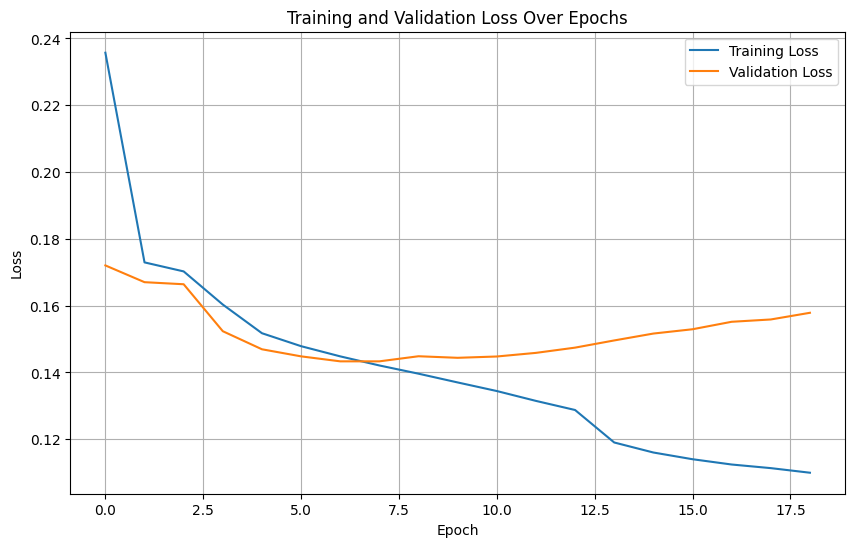

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_1 + train_losses_2, label='Training Loss')
plt.plot(val_losses_1 + val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Training and Validation Loss only Fine-tuning**

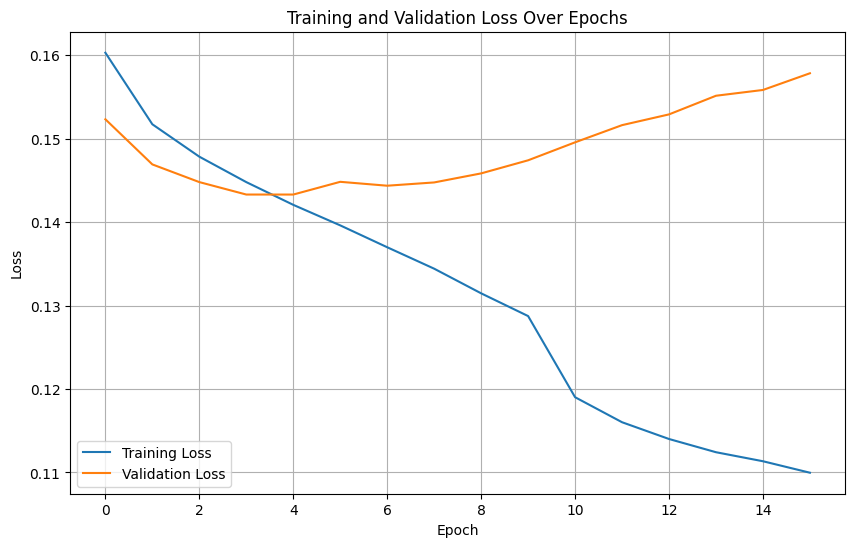

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label='Training Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

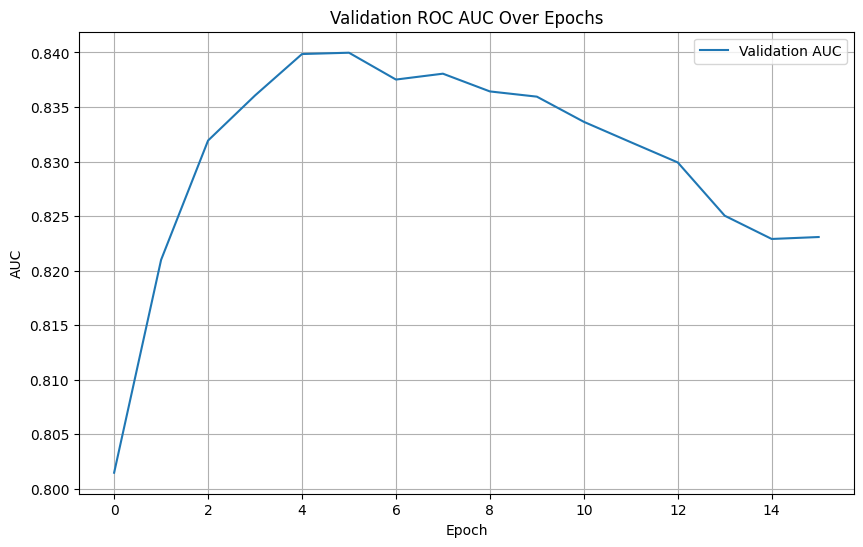

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC only Fine-tuning**

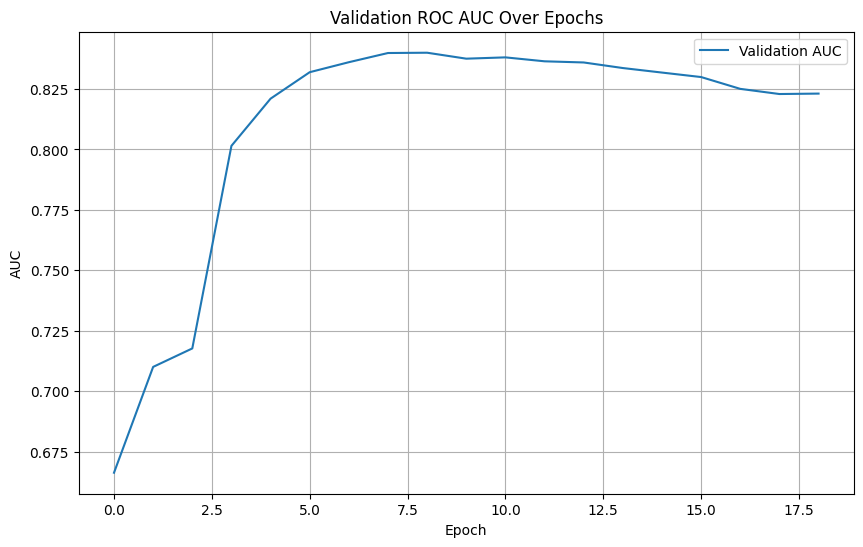

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_1 + val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot BYOL Loss**

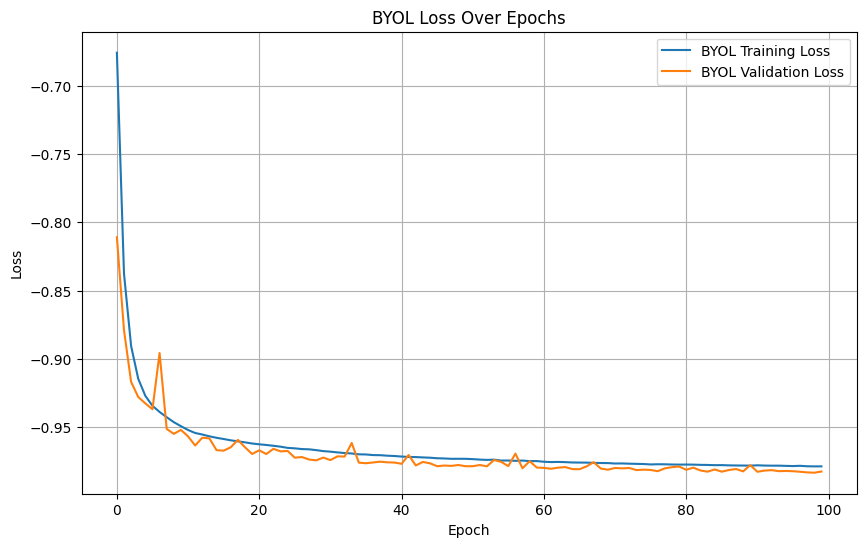

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(byol_train_losses, label='BYOL Training Loss')
plt.plot(byol_val_losses, label='BYOL Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BYOL Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()